In [1]:
import numpy as np
import time
import cv2
from boosting_classifier import Boosting_Classifier
from visualizer import Visualizer
from im_process import normalize
from utils import *

In [2]:
flag_subset = True
boosting_type = 'Ada' #'Real' or 'Ada'
training_epochs = 100 if not flag_subset else 20
act_cache_dir = 'wc_activations.npy' if not flag_subset else 'wc_activations_subset.npy'
chosen_wc_cache_dir = 'chosen_wcs.pkl' if not flag_subset else 'chosen_wcs_subset.pkl'

In [3]:
#data configurations
pos_data_dir = '../newface16'
neg_data_dir = '../nonface16'
image_w = 16
image_h = 16
data, labels = load_data(pos_data_dir, neg_data_dir, image_w, image_h, flag_subset)
data = integrate_images(normalize(data))

Load in 200 images, 100 faces, 100 non-faces


In [4]:
#number of bins for boosting
num_bins = 25

#number of cpus for parallel computing
num_cores = 8 if not flag_subset else 1 #always use 1 when debugging

In [5]:
#create Haar filters
filters = generate_Haar_filters(4, 4, 16, 16, image_w, image_h, flag_subset)

In [6]:
#create visualizer to draw histograms, roc curves and best weak classifier accuracies
drawer = Visualizer([1, 2, 4], [1, 2, 4])

## Toy example

In [7]:
fltr_indices = [0, 100, 300, 500, 800]
toy_filters = [filters[i] for i in fltr_indices]#five filters
toy_data = np.vstack((np.array(data[0:5, :, :]), np.array(data[190:195, :, :]))) #10 images
l1 = list(labels[0:5])
l2 = list(labels[190:195])
toy_labels =  np.array(l1+ l2)  #10 labels

In [8]:
toy_boost = Boosting_Classifier(toy_filters, toy_data, toy_labels, 4, num_bins, drawer, 1, "Ada")

In [9]:
activations = toy_boost.calculate_training_activations("toy_act_dir.npy", "toy_act_dir.npy")
print(activations)

Calcuate activations for 5 weak classifiers, using 10 imags.
[Find cached activations, toy_act_dir.npy loading...]
[[ 0.36078431  1.46666667 -0.29803922 -1.01960784 -0.15686275  0.54509804
   0.88235294 -0.17254902  0.29019608  0.57647059]
 [ 1.14509804  2.29411765  0.48235294  0.8745098   0.76862745  0.37647059
   0.45490196  0.78823529  0.90588235  0.79215686]
 [-0.58039216 -0.45882353  0.16078431  1.65882353 -0.43529412  0.1254902
  -1.2745098  -0.90196078  0.01568627 -0.45490196]
 [ 4.74117647  5.01568627  3.96862745  1.61568627  3.56470588  4.36078431
   6.12156863  1.30196078  1.27843137  5.78039216]
 [ 0.02352941  0.68627451 -0.02745098  0.34901961  0.30980392  0.28235294
  -0.04313725 -0.0627451   0.01568627  0.44705882]]


In [10]:
toy_boost.train()

threshold:  -0.2585034013605446
polarity:  -1
min error:  0.29999999999999993
alpha:  0.42364893019360195
Updated weak classifier attribute:  1
strong classifier scores:  [-0.42364893019360195, -0.42364893019360195, 0.42364893019360195, 0.42364893019360195, -0.42364893019360195, -0.42364893019360195, -0.42364893019360195, -0.42364893019360195, -0.42364893019360195, -0.42364893019360195]
...
threshold:  -0.8554621848739398
polarity:  1
min error:  0.25900974696901713
alpha:  0.525560888664397
Updated weak classifier attribute:  2
strong classifier scores:  [0.10191195847079504, 0.10191195847079504, 0.9492098188579989, 0.9492098188579989, 0.10191195847079504, 0.10191195847079504, -0.9492098188579989, -0.9492098188579989, 0.10191195847079504, 0.10191195847079504]
...
threshold:  0.9243697478991595
polarity:  1
min error:  0.2582981279197006
alpha:  0.5274164602006028
Updated weak classifier attribute:  3
strong classifier scores:  [0.6293284186713979, 0.6293284186713979, 0.421793358657396

[[0.42364893019360195,
 [0.525560888664397, <weak_classifier.Ada_Weak_Classifier at 0x7f989fda0358>],
 [0.5274164602006028, <weak_classifier.Ada_Weak_Classifier at 0x7f989fda08d0>],
 [0.5446248317004164, <weak_classifier.Ada_Weak_Classifier at 0x7f989fa980b8>]]

In [11]:
[toy_boost.sc_function(img) for img in toy_boost.data]

[0.08470358697098146,
 0.08470358697098146,
 0.9664181903578125,
 0.9664181903578125,
 0.11912032997060862,
 -0.9701293334302242,
 -2.0212511107590183,
 -0.9320014473581854,
 -0.9701293334302242,
 -0.9701293334302242]

In [12]:
toy_boost.visualizer.strong_classifier_scores

{0: [-0.42364893019360195,
  -0.42364893019360195,
  0.42364893019360195,
  0.42364893019360195,
  -0.42364893019360195,
  -0.42364893019360195,
  -0.42364893019360195,
  -0.42364893019360195,
  -0.42364893019360195,
  -0.42364893019360195],
 1: [0.10191195847079504,
  0.10191195847079504,
  0.9492098188579989,
  0.9492098188579989,
  0.10191195847079504,
  0.10191195847079504,
  -0.9492098188579989,
  -0.9492098188579989,
  0.10191195847079504,
  0.10191195847079504],
 2: [0.6293284186713979,
  0.6293284186713979,
  0.4217933586573961,
  0.4217933586573961,
  -0.4255045017298078,
  -0.4255045017298078,
  -1.4766262790586018,
  -1.4766262790586018,
  -0.4255045017298078,
  -0.4255045017298078],
 3: [0.08470358697098146,
  0.08470358697098146,
  0.9664181903578125,
  0.9664181903578125,
  0.11912032997060862,
  -0.9701293334302242,
  -2.0212511107590183,
  -0.9320014473581854,
  -0.9701293334302242,
  -0.9701293334302242]}

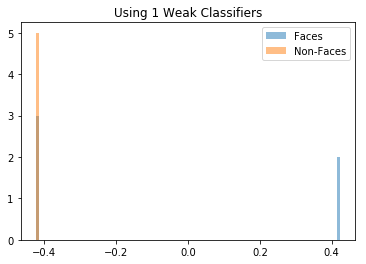

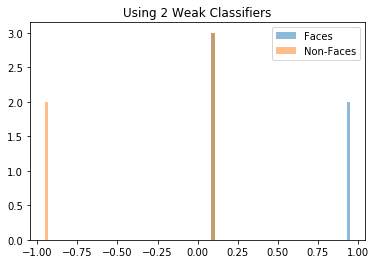

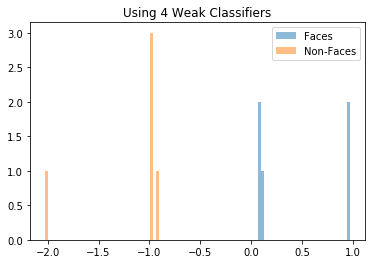

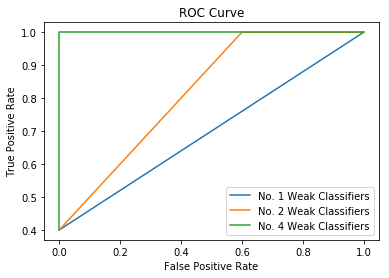

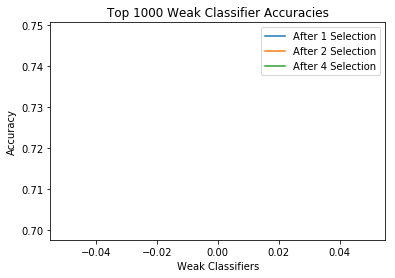

In [13]:
toy_boost.visualize()